## Clustering time series for classification

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from math import sqrt

from datetime import datetime
import pandas as pd
import numpy as np
import pdb


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score, completeness_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score

from dtaidistance import dtw

from collections import Counter

## The data

In [2]:
words = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/50words_TEST.csv',
                   header = None)

In [3]:
words.rename(columns = {0:'word'}, inplace = True) 

In [4]:
words.head()

,word,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,4,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.63754,-0.589370,-0.543420,...,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.17225,-0.087463,-0.019191,...,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
2,13,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.01550,-0.996720,-0.985040,...,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.19800,-1.27000
3,23,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.92649,-0.857090,-0.693320,...,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.05090,-1.12830
4,4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.57038,-0.506920,-0.446040,...,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.04180,-1.04030


## View output

In [5]:
words.word[1]

12

Text(0.5,0.98,'Sample word projections and histograms of the projections')

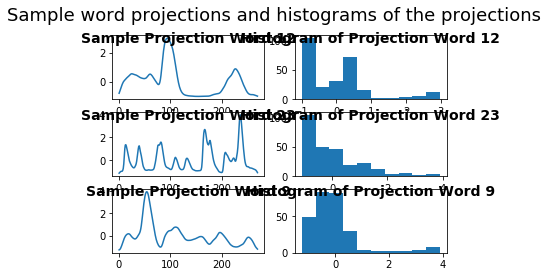

In [6]:
plt.subplot(3, 2, 1)
plt.plot(words.iloc[1, 1:-1])
plt.title("Sample Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 2)
plt.hist(words.iloc[1, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 3)
plt.plot(words.iloc[3, 1:-1])
plt.title("Sample Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 4)
plt.hist(words.iloc[3, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 5)
plt.plot(words.iloc[5, 1:-1])
plt.title("Sample Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 6)
plt.hist(words.iloc[5, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.suptitle("Sample word projections and histograms of the projections", fontsize = 18)

Text(0,0.5,'Value')

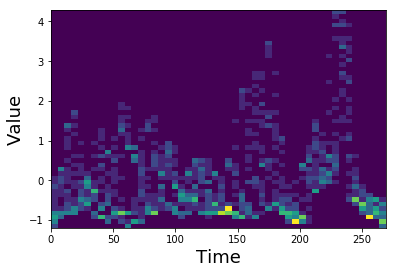

In [7]:

## We can also consider the 2d histogram of a word
x = np.array([])
y = np.array([])

w = 23
selected_words = words[words.word == w]
selected_words.shape

for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])
    
fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 50)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

## Generate some features

In [8]:
words.shape

(455, 271)

In [9]:
words_features = words.iloc[:, 1:271]

### Create some features from original time series

In [10]:
times  = []
values = []
for idx, row in words_features.iterrows():
    values.append(row.values)
    times.append(np.array([i for i in range(row.values.shape[0])]))

In [11]:
len(values)

455

In [12]:
# from cesium import featurize
# features_to_use = ["amplitude",
#                    "percent_beyond_1_std",
#                    "percent_close_to_median",
#                    ]
# featurized_words = featurize.featurize_time_series(times=times,
#                                               values=values,
#                                               errors=None,
#                                               features_to_use=features_to_use,
#                                               scheduler = None)

In [13]:
featurized_words = pd.read_csv("data/featurized_words.csv", header = [0, 1])
featurized_words.columns = featurized_words.columns.droplevel(-1)

In [14]:
featurized_words.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median
0,0,1.674555,0.188889,0.451852
1,1,1.990520,0.118519,0.259259
2,2,2.903650,0.114815,0.637037
3,3,2.515050,0.211111,0.562963
4,4,1.966150,0.181481,0.533333


In [15]:
featurized_words.shape

(455, 4)

(array([ 48., 146., 100.,  45.,  41.,  29.,  23.,  12.,   8.,   3.]),
 array([0.05925926, 0.10666667, 0.15407407, 0.20148148, 0.24888889,
        0.2962963 , 0.3437037 , 0.39111111, 0.43851852, 0.48592593,
        0.53333333]),
 <a list of 10 Patch objects>)

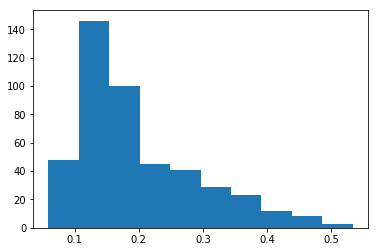

In [16]:
plt.hist(featurized_words.percent_beyond_1_std)

### Create some features from histogram

In [17]:
# times = []
# values = []
# for idx, row in words_features.iterrows():
#     values.append(np.histogram(row.values, bins=10, range=(-2.5, 5.0))[0] + .0001) ## cesium seems not to handle 0s
#     times.append(np.array([i for i in range(9)]))

In [18]:
# features_to_use = ["amplitude",
#                    "percent_close_to_median",
#                   "skew"
#                   ]
# featurized_hists = featurize.featurize_time_series(times=times,
#                                               values=values,
#                                               errors=None,
#                                               features_to_use=features_to_use,
#                                               scheduler = None)

In [19]:
# featurized_hists.to_csv("data/featurized_hists.csv")

In [20]:
featurized_hists = pd.read_csv("data/featurized_hists.csv", header = [0, 1])
featurized_hists.columns = featurized_hists.columns.droplevel(-1)

In [21]:
featurized_hists.head()

,feature,amplitude,percent_close_to_median,skew
0,0,88.0,0.444444,2.262655
1,1,61.0,0.666667,1.285343
2,2,70.0,0.666667,1.683031
3,3,67.0,0.555556,1.724109
4,4,75.0,0.777778,1.902513


In [22]:
features = pd.concat([featurized_words.reset_index(drop=True), featurized_hists], axis=1)

In [23]:
features.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,feature,amplitude,percent_close_to_median,skew
0,0,1.674555,0.188889,0.451852,0,88.0,0.444444,2.262655
1,1,1.990520,0.118519,0.259259,1,61.0,0.666667,1.285343
2,2,2.903650,0.114815,0.637037,2,70.0,0.666667,1.683031
3,3,2.515050,0.211111,0.562963,3,67.0,0.555556,1.724109
4,4,1.966150,0.181481,0.533333,4,75.0,0.777778,1.902513


In [24]:
words.shape

(455, 271)

In [25]:
## we also add some of our own features again, to account more for shape
feats = np.zeros( (words.shape[0], 1), dtype = np.float32)
for i in range(words.shape[0]):
    vals = words.iloc[i, 1:271].values
    feats[i, 0] = np.where(vals == np.max(vals))[0][0]

In [26]:
feats.shape

(455, 1)

In [27]:
features.shape

(455, 8)

In [28]:
features['peak_location'] = feats

In [29]:
features.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,feature,amplitude,percent_close_to_median,skew,peak_location
0,0,1.674555,0.188889,0.451852,0,88.0,0.444444,2.262655,186.0
1,1,1.990520,0.118519,0.259259,1,61.0,0.666667,1.285343,93.0
2,2,2.903650,0.114815,0.637037,2,70.0,0.666667,1.683031,69.0
3,3,2.515050,0.211111,0.562963,3,67.0,0.555556,1.724109,235.0
4,4,1.966150,0.181481,0.533333,4,75.0,0.777778,1.902513,174.0


In [30]:
feature_values = preprocessing.scale(features.iloc[:, [1, 2, 3, 5, 6, 7]])

In [31]:

clustering = AgglomerativeClustering(n_clusters=50, linkage='ward')
clustering.fit(feature_values)
words['feature_label'] = clustering.labels_

In [32]:
words['feature_label'] = words.feature_label.astype('category')

In [33]:
## the number of feature labels 
results = words.groupby('word')['feature_label'].agg({'num_clustering_labels': lambda x: len(set(x)),
                                            'num_word_samples':      lambda x: len(x),
                                            'most_common_label':     lambda x: Counter(x).most_common(1)[0][0]})
results.head()

/home/aileen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


,num_clustering_labels,num_word_samples,most_common_label
word,,,
1,19,57,38
2,19,42,29
3,16,28,37
4,17,34,17
5,13,25,8


In [34]:
## the number of feature labels 
results_feats = words.groupby('feature_label')['word'].agg({'num_words': lambda x: len(set(x)),
                                            'num_feat_samples':      lambda x: len(x),
                                            'most_common_word':     lambda x: Counter(x).most_common(1)[0][0]})
results_feats
## note that word 1 = most common in cluster 38

/home/aileen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


,num_words,num_feat_samples,most_common_word
feature_label,,,
0,9,16,2
1,5,5,13
2,7,8,16
3,8,9,1
4,10,20,1
5,4,8,2
6,5,6,15
7,6,6,7
8,6,17,5


In [35]:
homogeneity_score(words.word, words.feature_label)
## see definitions in user manual: https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness

0.5085776345414814

## Dynamic Time Warping Distance Definition

## Exercise: use what we discussed about dynamic programming to code a DTW function

In [36]:
X = words.iloc[:, 1:271].values

In [38]:
def distDTW(ts1, ts2):
    DTW       = np.full((len(ts1) + 1, len(ts2) + 1), 0, dtype = np.float32)
    DTW[:, 0] = np.inf
    DTW[0, :] = np.inf
    DTW[0, 0] = 0

    for i in range(1, len(ts1) + 1):
        for j in range(1, len(ts2) + 1):
            idx1 = i - 1 
            idx2 = j - 1
            
            dist               = (ts1[idx1] - ts2[idx2])**2
            min_preceding_dist = min(DTW[i-1, j],DTW[i, j-1], DTW[i-1, j-1])

            DTW[i, j] = dist + min_preceding_dist

    return sqrt(DTW[len(ts1), len(ts2)])

In [39]:
distDTW(X[0], X[1])

7.777960024318239

In [40]:
dtw.distance(X[0], X[1])
## worth checking out: https://github.com/wannesm/dtaidistance

7.777960164340302

In [41]:
# p = pairwise_distances(X, metric = distDTW)

In [42]:
# with open("pairwise_word_distances.npy", "wb") as f:
#     np.save(f, p)

In [43]:
p = np.load("data/pairwise_word_distances.npy")

## Try clustering based on dynamic time warping distances

In [44]:
## We will use hierarchical clustering as a distance agnostic methodology

In [45]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=50, affinity = 'precomputed') 
## 'average' linkage is good for non Euclidean distance metrics

In [46]:
labels = clustering.fit_predict(p)

In [47]:
len(words.word)

455

In [48]:
len(labels)

455

In [49]:

print(homogeneity_score(words.word, labels))
print(completeness_score(words.word, labels))

0.8286055510058652
0.923840473866547


In [50]:
# quoting: https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness
# homogeneity: each cluster contains only members of a single class.
# completeness: all members of a given class are assigned to the same cluster.

In [51]:
res = contingency_matrix(labels, words.word)

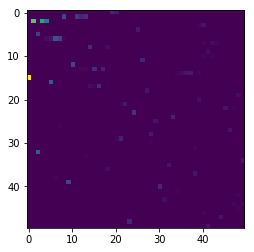

In [52]:
## note difficulties in assessing this given imbalanced dataset
plt.imshow(res)